In [1]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

# Building Bear Classifier Model

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '154dc8f8de094d678f48aee49a775c8d')

Create `bears` directory and download images from `Bing` 

In [4]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [5]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
fns = get_image_files(path)
fns

(#390) [Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000107.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/grizzly/00000110.jpg'),Path('bears/grizzly/00000112.jpg'),Path('bears/grizzly/00000091.jpg'),Path('bears/grizzly/00000093.jpg'),Path('bears/grizzly/00000090.jpg')...]

There might be some images that are corrupt. So we need to check and delete from our data

In [7]:
failed = verify_images(fns)
failed

(#4) [Path('bears/grizzly/00000038.jpg'),Path('bears/grizzly/00000020.jpg'),Path('bears/black/00000031.jpg'),Path('bears/teddy/00000010.jpg')]

In [8]:
failed.map(Path.unlink)

(#4) [None,None,None,None]

Now, we create template for "data holder"

In [12]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)    
)

Next, we load images by using dataloaders

In [13]:
dls = bears.dataloaders(path)

Using `show_batch` to check some of the images before train our model

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


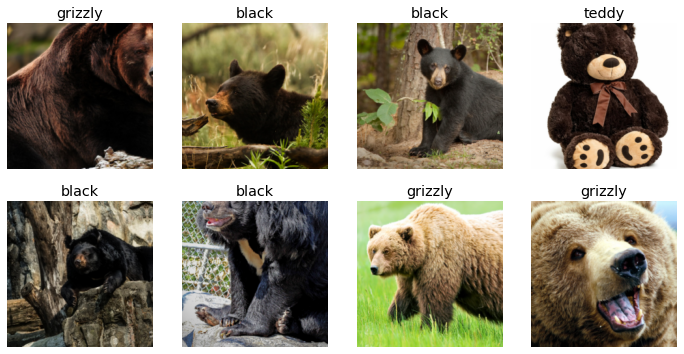

In [15]:
dls.show_batch(max_n=8, nrows=2, unique=False)

Now, we train our very first model 

In [16]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.402523,0.144382,0.038961,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.294220,0.089906,0.025974,00:15
1,0.167489,0.067669,0.038961,00:14
2,0.129349,0.061344,0.038961,00:15
3,0.098405,0.060368,0.025974,00:14


Let's see what makes our model confused the most

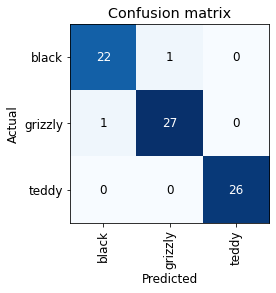

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

By using `plot_top_losses` function, we can get the wrong prediction as well as the one that our model is least confident of

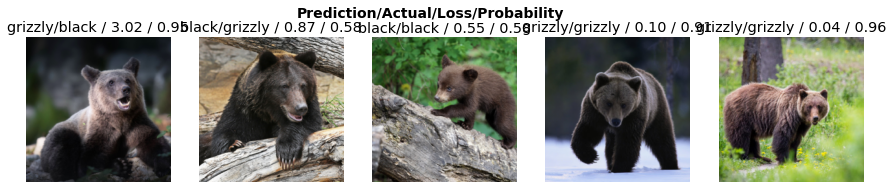

In [19]:
interp.plot_top_losses(5, nrows=1)

Now, it's time to look at the data and do some cleaning

In [20]:
cleaner = ImageClassifierCleaner(learn)
cleaner

After making some changes on `cleaner`, we should, then, tell the computer to apply those changes

In [25]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():
    if not (path/cat).exists():
        shutil.move(str(cleaner.fns[idx]), path/cat)

So it's time to train our model again!!!!

In [27]:
dls = bears.dataloaders(path)
learn= cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.421070,0.179513,0.064935,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.261713,0.075946,0.012987,00:15
1,0.185200,0.056258,0.012987,00:13
2,0.137342,0.047910,0.012987,00:15
3,0.109229,0.044208,0.012987,00:14


As we can see, our model are getting better after some changes are made on the data

Finally, we can save our model by using `export`

In [28]:
learn.export()

our model is saved on the file called `export.pkl`

In [29]:
modelPath = Path()
modelPath.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]